In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
sns.set_style('whitegrid')

In [2]:
# Load your preprocessed dataset
data = pd.read_parquet('n_forecast_preprocessed.parquet', engine='pyarrow', dtype_backend='numpy_nullable')

# Convert the 'sales_date' column to a datetime type
data['sales_date'] = pd.to_datetime(data['sales_date'])

# Set the sales_date column as the index of the dataframe
data.set_index('sales_date', inplace=True)

In [3]:
data

,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,holiday_new_years_day,...,holiday_valentines_day,autumn_school_holiday,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed,working_hours
sales_date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,b9d487a30398d42ecff55c228ed5652b,6570,19,68,south,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
2019-01-02,c3e0c62ee91db8dc7382bde7419bb573,1773,6,30,middle,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
2019-01-02,07042ac7d03d3b9911a00da43ce0079a,5391,19,10,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
2019-01-02,b60c5ab647a27045b462934977ccad9a,2789,6,96,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,be6c7b094f88532b6c6b35bbcd525ee8,3101,19,11,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2022-12-31 07:00:00,2022-12-31 19:00:00,12.0
2022-12-31,8430b32b5bac908e765df8813d4405c5,3529,19,94,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2022-12-31 07:30:00,2022-12-31 21:00:00,13.5
2022-12-31,3a2a9aef4cbed81244820a091667c0bd,745,16,22,middle,0,0,0,0,0,...,0,0,0,0,1,0,0,2022-12-31 07:00:00,2022-12-31 23:00:00,16.0


In [4]:
data.head()

,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,holiday_new_years_day,...,holiday_valentines_day,autumn_school_holiday,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed,working_hours
sales_date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,b9d487a30398d42ecff55c228ed5652b,6570,19,68,south,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
2019-01-02,c3e0c62ee91db8dc7382bde7419bb573,1773,6,30,middle,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
2019-01-02,07042ac7d03d3b9911a00da43ce0079a,5391,19,10,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
2019-01-02,b60c5ab647a27045b462934977ccad9a,2789,6,96,north,0,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0


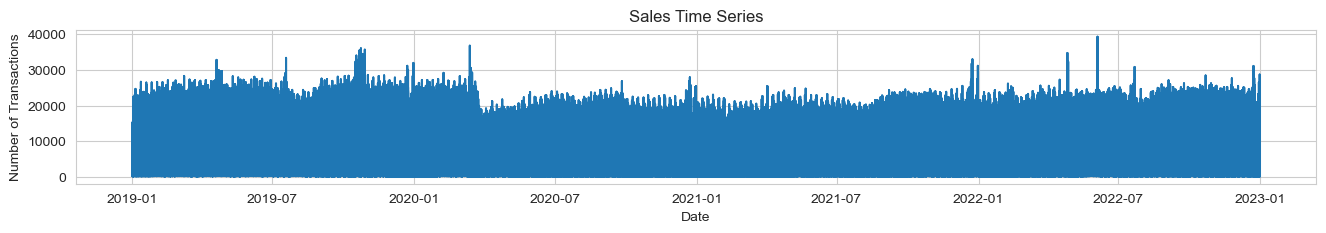

In [7]:
# Create a line plot of the time series
plt.figure(figsize=(16, 2))
plt.plot(data.index, data['n_transactions'])
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Sales Time Series')
plt.show()

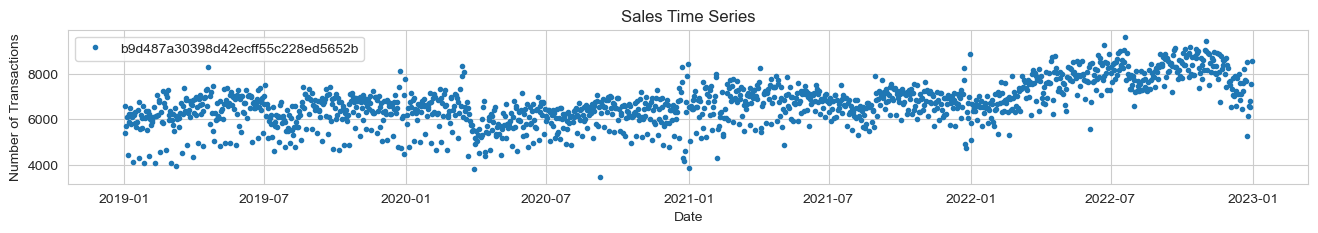

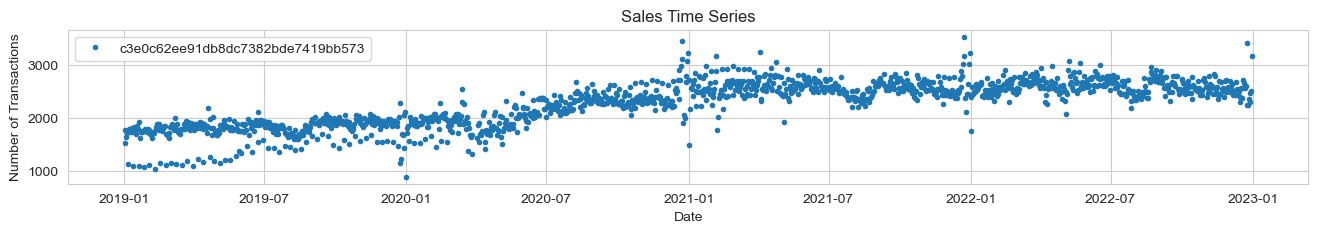

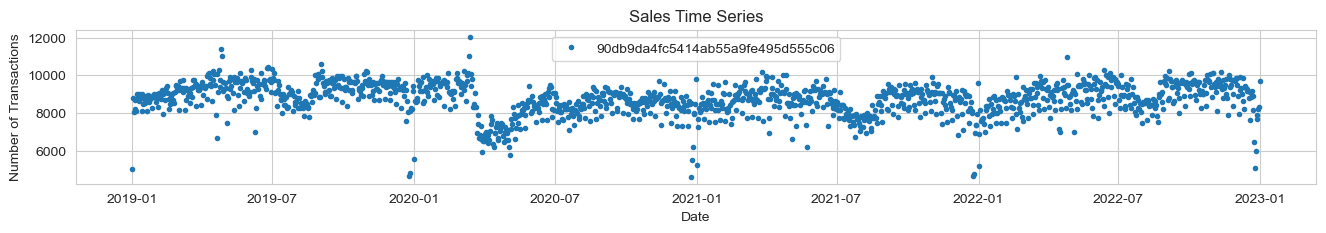

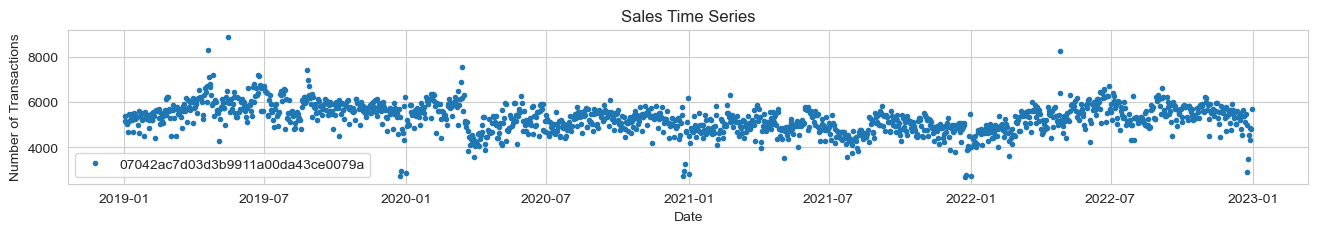

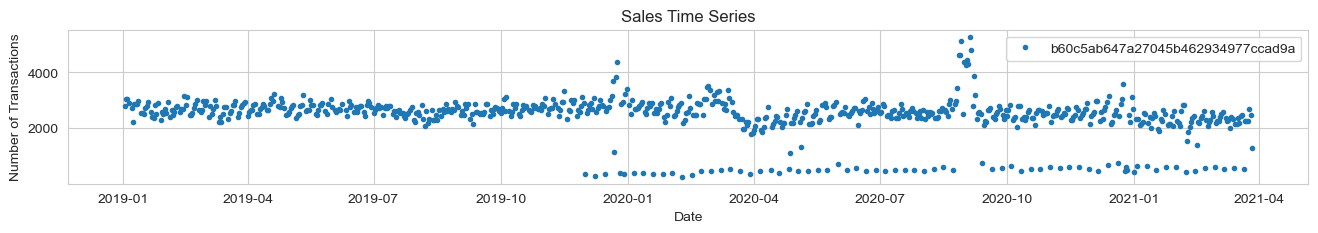

In [8]:
# Vizualize the time series per store
# I will use the first 5 stores

# Create a line plot of the time series

for store in data['store_hashed'].unique()[:5]:
    plt.figure(figsize=(16, 2))
    plt.plot(data[data['store_hashed'] == store].index, data[data['store_hashed'] == store]['n_transactions'], label=store, marker='.', linestyle='None')
    plt.xlabel('Date')
    plt.ylabel('Number of Transactions')
    plt.title('Sales Time Series')
    plt.legend()
    plt.show()


# Time Series Decomposition

In [22]:
# # remove index
data.reset_index(inplace=True)

In [23]:
# Time Series Plot for all unique stores: Filter data for a specific store (replace 'store_id' with your desired store id)
unique_stores = data.copy()
unique_stores = unique_stores['store_hashed'].unique()

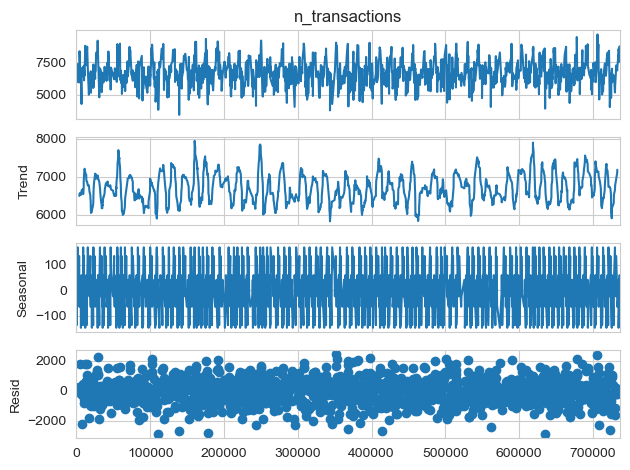

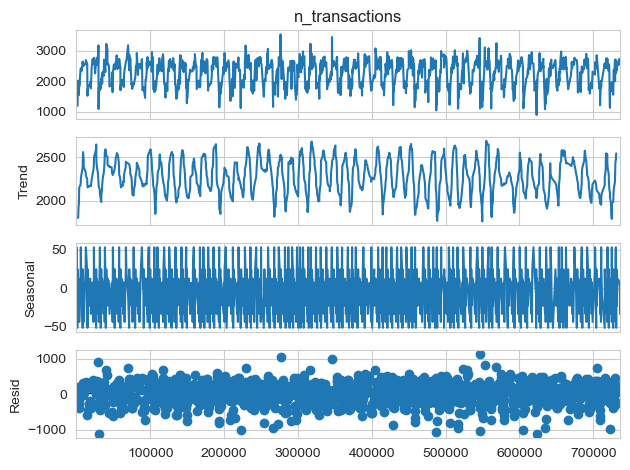

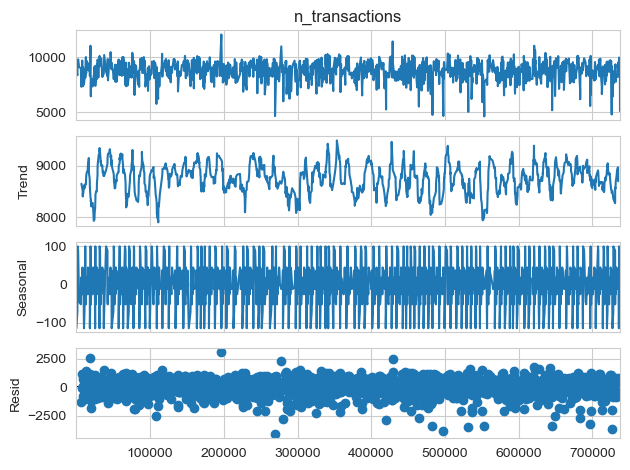

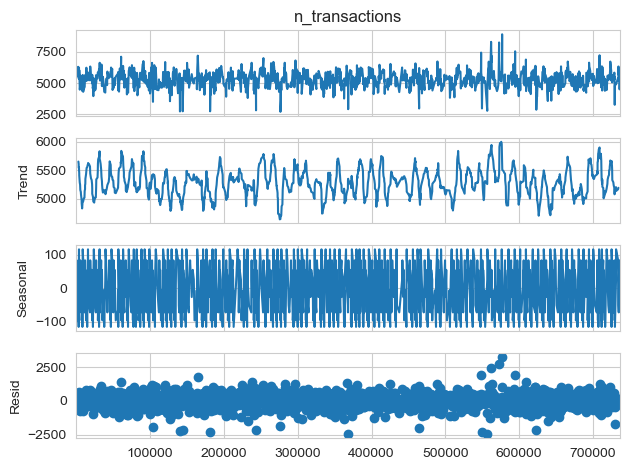

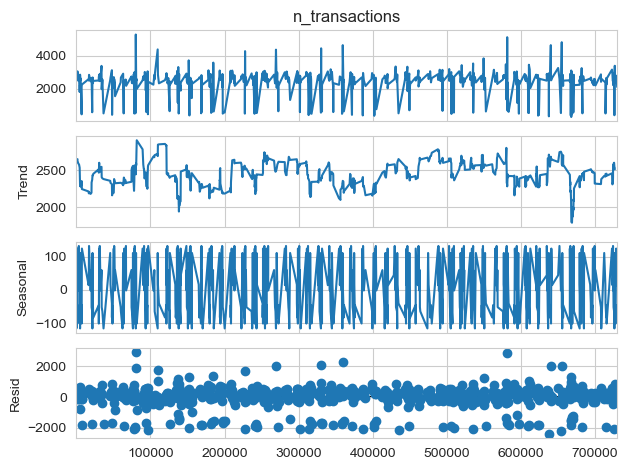

In [24]:
# Other way for seasonal decomposition
for store_id in unique_stores[:5]:
    series = data[data['store_hashed'] == store_id]['n_transactions']
    result = seasonal_decompose(series, model='aditive', period=15)
    result.plot()
    subtitle = 'Seasonal Decomposition of Store ' + str(store_id)
    plt.show()

In [28]:
# for store in unique_stores get the trend and seasonality
trend = []
seasonality = []

for store_id in unique_stores:
    series = data[data['store_hashed'] == store_id]['n_transactions']
    result = seasonal_decompose(series, model='multiplicative', period=15)
    trend.append(result.trend)
    seasonality.append(result.seasonal)


In [26]:
trend[:10]

[0        NaN
 395      NaN
 481      NaN
 1709     NaN
 2029     NaN
           ..
 734688   NaN
 734773   NaN
 735781   NaN
 736146   NaN
 736685   NaN
 Name: trend, Length: 1456, dtype: float64,
 1        NaN
 31       NaN
 50       NaN
 902      NaN
 1010     NaN
           ..
 732484   NaN
 732864   NaN
 735262   NaN
 736188   NaN
 736339   NaN
 Name: trend, Length: 1453, dtype: float64,
 2        NaN
 1355     NaN
 1670     NaN
 2360     NaN
 3694     NaN
           ..
 736063   NaN
 736152   NaN
 737019   NaN
 737183   NaN
 737359   NaN
 Name: trend, Length: 1461, dtype: float64,
 3        NaN
 388      NaN
 486      NaN
 635      NaN
 771      NaN
           ..
 735175   NaN
 736091   NaN
 736258   NaN
 736623   NaN
 736813   NaN
 Name: trend, Length: 1460, dtype: float64,
 4        NaN
 79       NaN
 636      NaN
 671      NaN
 920      NaN
           ..
 727783   NaN
 727902   NaN
 728704   NaN
 729384   NaN
 730045   NaN
 Name: trend, Length: 761, dtype: float64,
 5        N

In [27]:
seasonality[:10]

[0         0.997814
 395       0.978610
 481       1.004243
 1709      1.024930
 2029      1.010383
             ...   
 734688    0.991945
 734773    0.979070
 735781    0.997224
 736146    1.008021
 736685    0.997814
 Name: seasonal, Length: 1456, dtype: float64,
 1         0.979213
 31        1.010586
 50        1.023822
 902       1.008871
 1010      0.994957
             ...   
 732484    1.001209
 732864    1.005622
 735262    1.004373
 736188    1.001605
 736339    0.985435
 Name: seasonal, Length: 1453, dtype: float64,
 2         0.986556
 1355      0.991686
 1670      1.012200
 2360      1.009908
 3694      0.994625
             ...   
 736063    0.991686
 736152    1.012200
 737019    1.009908
 737183    0.994625
 737359    0.993810
 Name: seasonal, Length: 1461, dtype: float64,
 3         1.004941
 388       1.016359
 486       0.993916
 635       1.010246
 771       1.004696
             ...   
 735175    1.004941
 736091    1.016359
 736258    0.993916
 736623    1.010246